<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Intro_rcwa_simulate_differentiate_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script provides a simple example for how to use the RCWA solver and simulate a field. We also show how to explicitly call for the gradients. 

This type of implementation is done in the backend of the rcwa_layer calls but it is certainly useful to know how to implement your own version for exploring new studies 

# Clone D$\flat$ Repository and Install

DFlat is a relatively large package as it contains raw data files for nanocell libraries and pre-trained neural models. It may take a few minutes to download

In [1]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2773, done.
remote: Counting objects: 100% (792/792), done.
remote: Compressing objects: 100% (528/528), done.
remote: Total 2773 (delta 289), reused 707 (delta 251), pack-reused 1981
Receiving objects: 100% (2773/2773), 756.24 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (869/869), done.
Updating files: 100% (507/507), done.
Filtering content: 100% (19/19), 77.20 MiB | 818.00 KiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/DFla

In [2]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=78ccffd7422965e52d71450ba2509a604d9bfb2dbf283633fe1069156761a924
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.wh

# Run a RCWA Simulation

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import dflat.physical_optical_layer as df_physical
import dflat.data_structure as df_struct

To run a simulation, first we need to create the RCWA solver paramters object. Here, you specify the material used and the params object will internally grab and store the broadband, complex refractive index into its class attributes. 

You can specify a material from the list below or you can pass in a complex, float instead. 

In [4]:
df_physical.list_materials()

['TiO2', 'SiO2', 'Vacuum', 'Si', 'Si3N4']

In [18]:
wavelength_set_m = np.arange(400e-9, 750e-9, 10e-9)
fourier_modes = 7
rcwa_parameters = df_struct.rcwa_params(
    {
        "wavelength_set_m": wavelength_set_m,
        "thetas": [0.0 for i in wavelength_set_m],
        "phis": [0.0 for i in wavelength_set_m],
        "pte": [1.0 for i in wavelength_set_m],
        "ptm": [1.0 for i in wavelength_set_m],
        "pixelsX": 1,
        "pixelsY": 1,
        "PQ": [fourier_modes, fourier_modes],
        "Lx": 350e-9,
        "Ly": 350e-9,
        "L": [650.0e-9],
        "Lay_mat": ["Vacuum"],
        "material_dielectric": "TiO2",
        "er1": "SiO2",
        "er2": "Vacuum",
        "Nx": 512,
        "Ny": 512
    }
)

Now, let us write our own solver function from scratch. The goal is that we may pass in the rcwa_parameters and a binary_mask representing the nanostructure on the cell. This function can then inject the correct permittivity values and call the rcwa_solver.  

In this example I am only simulating a single layer but I have written the function with an open mind to enable multi-layer with minimal modification (it is a good practice to do so!)

In [19]:
def rcwa_calc_field(rcwa_parameters, binary_mask):
    ###
    batchSize = rcwa_parameters["batchSize"]
    pixelsX = rcwa_parameters["pixelsX"]
    pixelsY = rcwa_parameters["pixelsY"]
    Nx = rcwa_parameters["Nx"]
    Ny = rcwa_parameters["Ny"]
    Nlay = rcwa_parameters["Nlay"]
    dtype = rcwa_parameters["dtype"]
    cdtype = rcwa_parameters["cdtype"]

    materials_shape = (batchSize, pixelsX, pixelsY, Nlay, Nx, Ny)
    PQ_zero = tf.math.reduce_prod(rcwa_parameters["PQ"]) // 2
    lay_eps_list = rcwa_parameters["lay_eps_list"]

    # Assemble cell
    binary = tf.complex(tf.cast(binary_mask, dtype=dtype), tf.cast(0.0, dtype=dtype))
    UR = rcwa_parameters["urd"] * tf.ones(materials_shape, dtype=cdtype)
    ER_list = []
    for i, lay_eps in enumerate(lay_eps_list):
        ER_list.append(lay_eps_list[i] + (rcwa_parameters["erd"] - lay_eps_list[i]) * binary[i])
    ER = tf.concat(values=ER_list, axis=3)

    ## Call Simulation
    outputs = df_physical.simulate(ER, UR, rcwa_parameters)
    tx = outputs["tx"][:, :, :, PQ_zero, 0] # Get the zero order field by PQ_zero
    ty = outputs["ty"][:, :, :, PQ_zero, 0] 
    field = tf.expand_dims(tf.transpose(tf.stack((tx, ty))), 0)

    return field

Now let us define a simple cell structure and ideally assemble the structure in a way that is differentiable. Then we can obtain gradients later. 

In [28]:
def make_nanofin_mask(rcwa_parameters, finx, finy):
  # Create a grid
  Nx, Ny = rcwa_parameters["Nx"], rcwa_parameters["Ny"]
  Lx, Ly = rcwa_parameters["Lx"], rcwa_parameters["Ly"]
  xx, yy = np.meshgrid(np.linspace(-Lx/2, Lx/2, Nx), np.linspace(-Ly/2, Ly/2, Ny))

  power_exp = 50
  sigmoid_coeff=1000
  mask = 1 - tf.math.abs(xx * 2 / finx) ** power_exp - tf.math.abs(yy * 2 / finy) ** power_exp
  mask = tf.math.sigmoid(sigmoid_coeff * mask)

  return tf.expand_dims(mask,0)

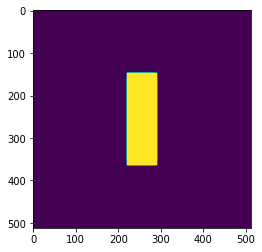

In [21]:
out = make_nanofin_mask(rcwa_parameters, 50e-9, 150e-9)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(out[0])

Now let us combine our cell assembly function with our solve function to compute the fields

In [22]:
binary_mask = make_nanofin_mask(rcwa_parameters, 50e-9, 150e-9)
transmitted_field = rcwa_calc_field(rcwa_parameters, binary_mask)
transmitted_field = tf.squeeze(transmitted_field)

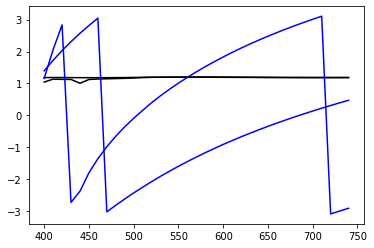

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength_set_m *1e9, np.abs(transmitted_field.numpy()), 'k-')
ax.plot(wavelength_set_m *1e9, np.angle(transmitted_field.numpy()), 'b-')

# Call gradients 

For this example, let us just use an objective function arbitrarily defined according to the sum of transmission. This is not particularly practical for a dieletric nano-cell but you can still compute the gradients.

To do this, we use the tf gradientTape method

In [44]:
finx = tf.Variable(60e-9, trainable=True)
finy = tf.Variable(160e-9, trainable=True)
Lx, Ly = rcwa_parameters["Lx"], rcwa_parameters["Ly"]

with tf.GradientTape() as tape:
  # Calculation
  binary_mask = make_nanofin_mask(rcwa_parameters, finx, finy)
  transmitted_field = rcwa_calc_field(rcwa_parameters, binary_mask)
  transmitted_field = tf.squeeze(transmitted_field)
   
  # objective function
  energy = tf.math.reduce_sum(tf.math.abs(transmitted_field)**2)

# Get gradients
gradients = tape.gradient(energy, [finx, finy])

In [45]:
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=2.6016016e-26>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0891512e-27>]
